In [328]:
# 3rd party
import sympy as sp
import numpy as np
from IPython.utils.io import capture_output
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# Our stuff
import mainframe as mf
import nuclei_func as nf
from mainframe import Region

In [329]:
################################################################################
# INPUT DATA
################################################################################
tank_height = 40 # Tank height [cm]
radius = 20 # Tank / person radius [cm]
rho_H2O = 1 # Water density [g/cm3]
N_av = 6.022 * 10 ** 23 # Avogadro number [atoms/mol]
MM_water = 18.015 # Water molar mass [g/mol]
nu_0 = 2.405 # Fundamental solution for the radial part (Bessel)

# Value to change for the second evaluation
Buckling_ratio = 0.93

# Cross sections
micro_abs_water = 0.66 # person is assumed to be a cylinder of water
macro_abs_person = nf.macro(micro_abs_water, 1, 18)
display(Latex(r'$\Sigma_{abs} = ' + sp.latex(macro_abs_person) + r'$'))

# Cross section of the barrel [Be, U235]
x_235 = sp.symbols('x_235', positive=True, real=True)
density_barrel = nf.mixture([1.845, 18.9], [1-x_235, x_235], 'normalize')
MM_barrel = nf.mixture([9, 235], [1-x_235, x_235], 'normalize')
micro_abs_barrel = nf.mixture([8.490e-3, 678],[1-x_235, x_235],'normalize')
micro_fiss_barrel = nf.mixture([0, 577], [1-x_235, x_235], 'normalize')
macro_abs_barrel = nf.macro(micro_abs_barrel, density_barrel, MM_barrel)
macro_fiss_barrel = nf.macro(micro_fiss_barrel, density_barrel, MM_barrel)
display(Latex(r'$\Sigma_{abs} = ' + sp.latex(macro_abs_barrel) + r'$'))
display(Latex(r'$\Sigma_{fiss} = ' + sp.latex(macro_fiss_barrel) + r'$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [330]:
################################################################################
# FUNCTION AND SYMBOLIC VARIABLES DEFINITION
################################################################################
z = sp.symbols('z')
r = sp.symbols('r')
lamda = sp.symbols('lambda', positive = True) 
# alfa = sp.symbols('alpha', Positive = True)
L_c = sp.symbols('L_c', positive = True)
L_p = sp.symbols('L_p', positive = True)
D_c = sp.symbols('D_c', positive = True) 
D_p = sp.symbols('D_p', positive = True) 
h_cyl = sp.symbols('H_cyl', positive = True) # Cylinder height
h_per = sp.symbols('h_per', positive = True) # Person height
F_cyl_z = sp.Function('phi_c,z', real = True)(z)
F_person_z = sp.Function('phi_p,z', real = True)(z)
F_cyl_radial = sp.Function('phi_c,r', real = True)(r) # Non so se serva, in realtà la parte radiale serve solo per B_g^2 = B_z^2 + B_r^2, con B_r^2 = (nu_0 / R)^2

In [331]:
################################################################################
# REGIONS DEFINITION
################################################################################
Barrel = Region(
    Diff=0.7, # Diffusion coefficient (tank) [cm]
    Abs=macro_abs_barrel, 
    Fiss=macro_fiss_barrel, 
    Nu=2.405, 
    Pos1=0, 
    Pos2=40, # Tank height [cm]
    composition='c', 
    power=0
)

Person = Region(
    Diff=0.16, # Diffusion coefficient (person) [cm]
    Abs=macro_abs_person, 
    Fiss=0, 
    Nu=0, 
    Pos1=40, 
    Pos2=40+h_per, # Person height [cm]
    composition='r', 
    power=0
)
regions = [Barrel, Person]

In [332]:
# Determine the Uranium fraction in the barrel
B_g = sp.sqrt((sp.pi / tank_height)**2 + (2.405 / radius)**2) # Geometrical Buckling
B_m = sp.sqrt(( Barrel.Nu*Barrel.Fission - Barrel.Absorption) / Barrel.Diffusion ) # Material Buckling 

condition = sp.Eq(Buckling_ratio*(B_g**2), B_m**2)

x_235_val = sp.solve(condition, x_235)[0]
display(Latex(f"Uranium fraction in the barrel: {x_235_val*100:.2f}%"))

<IPython.core.display.Latex object>

In [333]:
# Substitute the value of x_235 in the cross sections
Barrel.Absorption = Barrel.Absorption.subs(x_235, x_235_val)
Barrel.Fission = Barrel.Fission.subs(x_235, x_235_val)
B_m = sp.sqrt(( Barrel.Nu*Barrel.Fission - Barrel.Absorption) / Barrel.Diffusion ) # Material Buckling

display(Latex(r'$\Sigma_{abs} = ' + sp.latex(Barrel.Absorption) + r'$'))
display(Latex(r'$\Sigma_{fiss} = ' + sp.latex(Barrel.Fission) + r'$'))
display(Latex(r'$B_m^2 = ' + sp.latex((B_m**2).evalf()) + r'$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [334]:
# ODE + BC

ODE_c_z = sp.Eq(sp.diff(sp.diff(F_cyl_z, z)) + lamda** 2 * F_cyl_z, 0)
print('AXIAL ODE FOR THE CORE:')
display(ODE_c_z)

# ODE_c_r = sp.Eq((1 /r) * sp.diff(1/r *sp.diff(F_cyl_radial, r)) + alfa** 2 * F_cyl_z, 0)
# print('RADIAL ODE FOR THE CORE:')
# display(ODE_c_r)

ODE_p_z = sp.Eq(sp.diff(sp.diff(F_person_z, z)) - (1 / L_p** 2) * F_person_z, 0)
print('AXIAL ODE FOR THE PERSON:')
display(ODE_p_z)

AXIAL ODE FOR THE CORE:


Eq(lambda**2*phi_c,z(z) + Derivative(phi_c,z(z), (z, 2)), 0)

AXIAL ODE FOR THE PERSON:


Eq(Derivative(phi_p,z(z), (z, 2)) - phi_p,z(z)/L_p**2, 0)

In [335]:
flux_c_z = sp.dsolve(ODE_c_z)
sC1 = sp.symbols('C_1', real=True)   
sC2 = sp.symbols('C_2', real=True)
flux_c_z = flux_c_z.subs({sp.symbols('C1'): sC1, sp.symbols('C2'): sC2})
print('GENERAL SOLUTION FOR THE AXIAL FLUX IN THE CORE:')
display(flux_c_z)

flux_p_z = sp.dsolve(ODE_p_z)
sC3 = sp.symbols('C_3', real=True)
sC4 = sp.symbols('C_4', real=True)
flux_p_z = sp.Eq(
    flux_p_z.lhs,
    sC3 * sp.sinh((z-tank_height)/L_p) + sC4 * sp.cosh((z-tank_height)/L_p)
)
print('GENERAL SOLUTION FOR THE AXIAL FLUX IN THE PERSON:')
display(flux_p_z)

# flux_r = sp.dsolve(ODE_c_r)
# print('GENERAL SOLUTION FOR THE FLUX IN THE REFLECTOR:')
# display(flux_r)

GENERAL SOLUTION FOR THE AXIAL FLUX IN THE CORE:


Eq(phi_c,z(z), C_1*sin(lambda*z) + C_2*cos(lambda*z))

GENERAL SOLUTION FOR THE AXIAL FLUX IN THE PERSON:


Eq(phi_p,z(z), C_3*sinh((z - 40)/L_p) + C_4*cosh((z - 40)/L_p))

In [336]:
# Symmetry BC
symmetry = sp.Eq(
    sp.diff(flux_c_z.rhs, z).subs(z, tank_height/2), 
    0 
)
print('SYMMETRY CONDITION IN THE CORE:')
display(symmetry)

SYMMETRY CONDITION IN THE CORE:


Eq(C_1*lambda*cos(20.0*lambda) - C_2*lambda*sin(20.0*lambda), 0)

In [337]:
# Continuity BC
continuity_f = sp.Eq(
    flux_c_z.rhs.subs(z, tank_height), 
    flux_p_z.rhs.subs(z, tank_height)
)
print('CONTINUITY CONDITION FOR THE FLUX AT THE INTERFACE:')
display(continuity_f)

continuity_curr = sp.Eq(
    -D_c* sp.diff(flux_c_z.rhs, z).subs(z, tank_height),
    -D_p * sp.diff(flux_p_z.rhs, z).subs(z, tank_height)
    )
print('CONTINUITY CONDITION FOR THE CURRENT AT THE INTERFACE:')
display(continuity_curr)

CONTINUITY CONDITION FOR THE FLUX AT THE INTERFACE:


Eq(C_1*sin(40*lambda) + C_2*cos(40*lambda), C_4)

CONTINUITY CONDITION FOR THE CURRENT AT THE INTERFACE:


Eq(-D_c*(C_1*lambda*cos(40*lambda) - C_2*lambda*sin(40*lambda)), -C_3*D_p/L_p)

In [338]:
# # Vacuum BC REDUNDANT
vacuum_core = sp.Eq(
    flux_c_z.rhs.subs(z, 0),
    0
)
print('VACUUM CONDITION IN THE CORE:')
display(vacuum_core)

# Person BC
vacuum_person = sp.Eq(
    flux_p_z.rhs.subs(z, h_per),
    0
)
print('VACUUM CONDITION IN THE PERSON:')
display(vacuum_person)

VACUUM CONDITION IN THE CORE:


Eq(C_2, 0)

VACUUM CONDITION IN THE PERSON:


Eq(C_3*sinh((h_per - 40)/L_p) + C_4*cosh((h_per - 40)/L_p), 0)

In [339]:
equations = [flux_c_z, flux_p_z, vacuum_core, continuity_f, continuity_curr, vacuum_person]
with capture_output() as captured:
    system = [eq.subs(D_p, Person.Diffusion).subs(D_c, Barrel.Diffusion) for eq in mf.compute(equations, regions) if eq != True]
for eq in system:
    display(eq)

Eq(phi_c,z(z), C_1*sin(lambda*z))

Eq(phi_p,z(z), C_3*sinh((z - 40)/L_p) + C_4*cosh((z - 40)/L_p))

Eq(C_1*sin(40*lambda), C_4)

Eq(-0.7*C_1*lambda*cos(40*lambda), -0.16*C_3/L_p)

Eq(C_3*sinh((h_per - 40)/L_p) + C_4*cosh((h_per - 40)/L_p), 0)

In [340]:
# From 3rd and 4th equation we can find the values of C3 and C4
sub_system = [system[2], system[3]]
sub_sol = sp.solve(sub_system, [sC3, sC4])

# Substitute the values of C3 and C4 in the general solution for the person flux
condition = system[4].subs(sub_sol)
display(condition)

Eq(4.375*C_1*L_p*lambda*cos(40.0*lambda)*sinh((h_per - 40)/L_p) + C_1*sin(40.0*lambda)*cosh((h_per - 40)/L_p), 0)

In [341]:
# Manipulate the expression
f_s = condition.lhs.as_ordered_terms()
f_1 = f_s[0]
f_2 = -f_s[1]
# Ratio between the two terms
ratio = sp.trigsimp(f_1 / f_2)
display(sp.Eq(ratio,1))

Eq(-4.375*L_p*lambda*tanh(h_per/L_p - 40/L_p)/tan(40.0*lambda), 1)

In [342]:
# Get the tanh on the rhs an leave its coefficient on the lhs
tanh_terms = ratio.atoms(sp.tanh)

# Get the first tanh term (assuming there is only one unique tanh term in the expression)
tanh_term = next(iter(tanh_terms))

# Extract the coefficient of the detected tanh term
coefficient = ratio.coeff(tanh_term)

# Eq to solve
condition = sp.Eq(tanh_term, 1 / coefficient)
display(condition)

Eq(tanh(h_per/L_p - 40/L_p), -0.228571428571429*tan(40.0*lambda)/(L_p*lambda))

In [343]:
# Substitute values
L_person_val = sp.sqrt(- Person.Absorption / Person.Diffusion - (2.405 / radius)**2)
# L_person_val = sp.sqrt((Person.Diffusion / Person.Absorption))
print(f"Person parameter: {L_person_val}")

B_radial = 2.405/radius
B_axial = np.pi/tank_height
B_m_reduced = Buckling_ratio * sp.sqrt(B_axial**2 + B_radial**2)
B_core_val = sp.sqrt(-B_m_reduced**2 + B_radial**2)
print(f"Barrel parameter: {B_core_val.evalf()}")

condition = condition.subs({L_p: L_person_val, lamda: B_core_val.evalf()})
# Divide both sides by i
condition = sp.Eq(sp.I * condition.lhs, sp.I * condition.rhs)
display(condition)

Person parameter: 0.390466681250355*I
Barrel parameter: 0.0581513850678887*I


Eq(tan(2.56103797844618*h_per - 102.441519137847), -9.87620410520952)

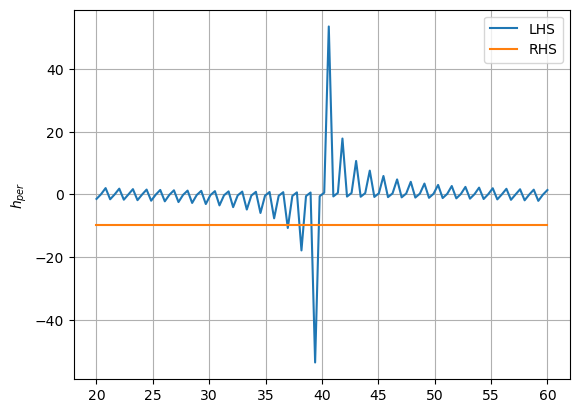

In [344]:
# Limits of the interval
start = 20
end = 60

plot_val = np.linspace(start, end, 100)
val_lhs = [condition.lhs.subs(h_per, i).evalf() for i in plot_val]
val_rhs = [condition.rhs for i in plot_val]

# Save these in a file
with open(f"data{Buckling_ratio}.txt", 'w') as f:
    for i in range(len(plot_val)):
        f.write(f'{plot_val[i]}\t{val_lhs[i]}\t{val_rhs[i]}\n')

# Plot the tanh function
plt.plot(plot_val, val_lhs, label='LHS')
plt.plot(plot_val, val_rhs, label='RHS')
plt.legend()
plt.ylabel('$h_{per}$')
plt.grid()


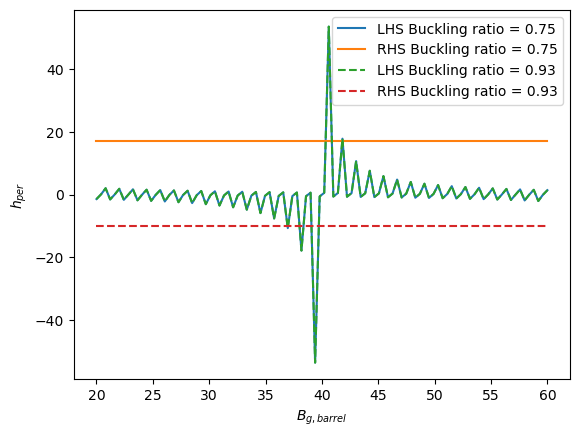

In [345]:
# Load the data from a file
data = np.loadtxt(f"data{0.75}.txt", delimiter='\t')
plt.plot(data[:,0], data[:,1], label='LHS Buckling ratio = 0.75')
plt.plot(data[:,0], data[:,2], label='RHS Buckling ratio = 0.75')
data = np.loadtxt(f"data{0.93}.txt", delimiter='\t')
plt.plot(data[:,0], data[:,1], label='LHS Buckling ratio = 0.93', linestyle='--')
plt.plot(data[:,0], data[:,2], label='RHS Buckling ratio = 0.93', linestyle='--')
plt.legend()
plt.xlabel('$B_{g,barrel}$')
plt.ylabel('$h_{per}$')
plt.show()